# Pyspatialml

Machine learning classification and regresssion modelling for spatial raster data.

## Example Classification

This is an example using the imagery data that is bundled with the package. This data is derived from the GRASS GIS North Carolina dataset and comprises Landsat 7 VNIR and SWIR bands along with some land cover training data that were derived from a land cover classification from an earlier date.

First, import the extract and predict functions:

In [1]:
from osgeo import gdal
from pyspatialml import predict
from pyspatialml.sampling import extract
import os
import geopandas
import rasterio.plot
import matplotlib.pyplot as plt

%matplotlib inline

The GDAL virtual tile format provides a simple method of stacking and aligning a list of separate raster datasets:

In [2]:
band1 = 'lsat7_2000_10.tif'
band2 = 'lsat7_2000_20.tif'
band3 = 'lsat7_2000_30.tif'
band4 = 'lsat7_2000_40.tif'
band5 = 'lsat7_2000_50.tif'
band7 = 'lsat7_2000_70.tif'
predictors = [band1, band2, band3, band4, band5, band7]

# stack the bands into a single virtual tile format dataset:
vrt_file = 'landsat.vrt'
outds = gdal.BuildVRT(
    destName=vrt_file, srcDSOrSrcDSTab=predictors, separate=True,
    resolution='highest', resampleAlg='bilinear')
outds.FlushCache()

# load the vrt as a rasterio dataset:
src = rasterio.open(vrt_file)

Load some training data:

In [3]:
training_py = geopandas.read_file('landsat96_polygons.shp')
training_pt = geopandas.read_file('landsat96_points.shp')
training_px = rasterio.open('landsat96_labelled_pixels.tif')

Show training data and a single raster band using numpy and matplotlib:

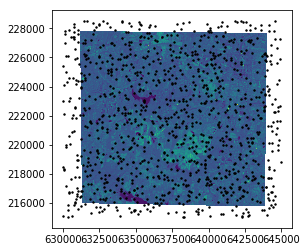

In [4]:
srr_arr = src.read(4, masked=True)
plt.imshow(srr_arr, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.scatter(x=training_pt.bounds.iloc[:, 0],
            y=training_pt.bounds.iloc[:, 1],
            s=2, color='black')
plt.show()

Create a training dataset by extracting the raster values at the training point locations:

In [5]:
X, y, xy = extract(dataset=src, response=training_pt, field='id')
X.shape

(885, 6)

A geodataframe containing polygon features can also be supplied to the extract function:

In [6]:
X, y, xy = extract(dataset=src, response=training_py, field='id')
X.shape

(2264, 6)

The response argument of the extract function can also take a raster data (GDAL-supported, single-band raster) where the training data are represented by labelled pixels:

In [7]:
X, y, xy = extract(dataset=src, response=training_px)
X.shape

(2872, 6)

The training data is returned as a masked array, with training points that intersect nodata values in the predictor rasters being masked. This can cause problems with sklearn, so here we use only the valid entries:

In [8]:
X = X[~X.mask.any(axis=1)]
y = y[~y.mask]
xy = xy[~xy.mask.any(axis=1)]

Note the extract function returns three numpy-arrays as a tuple, consisting of the extracted pixel values (X), the response variable value (y) and the sampled locations (2d numpy array of x,y values). These represent masked arrays with nodata values in the predictors being masked, and the equivalent entries in y and xy being masked on axis=0.

Next we can train a logistic regression classifier:

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# define the classifier with standardization of the input features in a pipeline
lr = Pipeline(
    [('scaling', StandardScaler()),
     ('classifier', LogisticRegressionCV(n_jobs=-1))])
 
# fit the classifier
lr.fit(X, y)

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

After defining a classifier, a typical step consists of performing a cross-validation to evaluate the performance of the model. Scikit-learn provides the cross_validate function for this purpose. In comparison to non-spatial data, spatial data can be spatially correlated, which potentially can mean that geographically proximal samples may not represent truely independent samples if they are within the autocorrelation range of some of the predictors. This will lead to overly optimistic performance measures if samples in the training dataset / cross-validation partition are strongly spatially correlated with samples in the test dataset / cross-validation partition.

In this case, performing cross-validation using groups is useful, because these groups can represent spatial clusters of training samples, and samples from the same group will never occur in both the training and test partitions of a cross-validation. An example of creating random spatial clusters from point coordinates is provided here:

In [10]:
from sklearn.cluster import KMeans

# create 10 spatial clusters based on clustering of the training data point x,y coordinates
clusters = KMeans(n_clusters=10, n_jobs=-1)
clusters.fit(xy)

# cross validate
scores = cross_validate(
  lr, X, y, groups=clusters.labels_,
  scoring='accuracy',
  cv=3,  n_jobs=1)
scores['test_score'].mean()

0.7365379685303056

Finally we might want to perform the prediction on the raster data. The estimator, raster and file_path fields are required. Predict_type can be either 'raw' to output a classification or regression result, or 'prob' to output class probabilities as a multi-band raster (a band for each class probability). In the latter case, indexes can also be supplied if you only want to output the probabilities for a particular class, or list of classes, by supplying the indices of those classes:

In [11]:
outfile = 'classification.tif'
result = predict(estimator=lr, dataset=src, file_path='classification.tif',
                 dtype='int16', nodata=0)

100%|██████████| 56/56 [00:00<00:00, 349.51it/s]


Display the results:

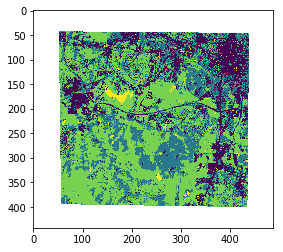

In [12]:
plt.imshow(result.read(1, masked=True))
plt.show()

### Sampling Tools

For many spatial models, it is common to take a random sample of the predictors to represent a single class (i.e. an environmental background or pseudo-absences in a binary classification model). The sample function is supplied in the sampling module for this purpose:

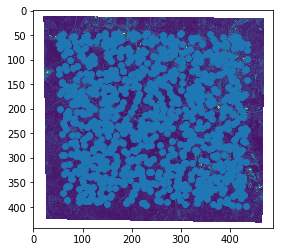

In [13]:
from pyspatialml.sampling import sample

# extract training data using a random sample
X, xy = sample(size=1000, dataset=src, random_state=1)

# display the samples
row, col = rasterio.transform.rowcol(src.transform, xs=xy[:, 0], ys=xy[:, 1])
plt.imshow(src.read(1, masked=True))
plt.scatter(x=col, y=row)
plt.show()

The sample function also enables stratified random sampling based on passing a categorical raster dataset to the strata argument. The categorical raster should spatially overlap with the dataset to be sampled, but it does not need to be of the same grid resolution.

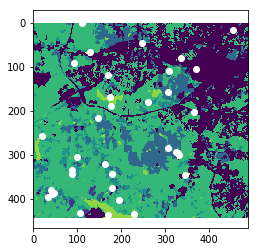

In [16]:
# extract training data using a stratified random sample from a map containing categorical data
# here we are taking 50 samples per category
strata = rasterio.open('strata.tif')
X, xy = sample(size=5, dataset=src, strata=strata, random_state=1)

row, col = rasterio.transform.rowcol(src.transform, xs=xy[:, 0], ys=xy[:, 1])
plt.imshow(strata.read(1, masked=True))
plt.scatter(x=col, y=row, color='white')
plt.show()


## Vector Data Tools

In some cases, we don't need all of the training data, but rather would spatially thin a point dataset. The filter_points function performs point-thinning based on a minimum distance buffer:

In [19]:
from pyspatialml.sampling import filter_points

training_xy = training_pt.bounds.iloc[:, 2:].values
thinned_points = filter_points(xy=training_xy, min_dist=500, remove='first')
thinned_points.shape

/Users/steven/GitHub/Pyspatialml/pyspatialml/sampling.py:323: RuntimeWarning: All-NaN slice encountered
  
/Users/steven/GitHub/Pyspatialml/pyspatialml/sampling.py:325: RuntimeWarning: invalid value encountered in greater_equal
  def get_random_point_in_polygon(poly):


(155, 2)

We can also generate random points within polygons using the get_random_point_in_polygon function. This requires a shapely POLYGON geometry as an input, and returns a shapely POINT object:

In [25]:
from pyspatialml.sampling import get_random_point_in_polygon

# generate 5 random points in a single polygon
random_points = [get_random_point_in_polygon(training_py.geometry[0]) for i in range(5)]

# convert to a GeoDataFrame
random_points = geopandas.GeoDataFrame(
  geometry=geopandas.GeoSeries(random_points))